# Figures for GMM-VAE

In [16]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision.utils import make_grid

sys.path.append(os.path.join(os.getcwd(), os.pardir))
from src.gmmvae import GMMVAE
from src.utils import *

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.family'] = "serif"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load model

In [17]:
root_path = "../results/95b6e868-04f3-11f0-be67-ab9e60786757"
model_params = load_params(root_path)
model = GMMVAE(input_dim=model_params["input_dim"],
               latent_dim=model_params["latent_dim"], 
               n_components=model_params["n_components"])

ckpt = load_ckpt(root_path)
model.load_state_dict(ckpt)
model.eval()
print("Model loaded")

Model params loaded


FileNotFoundError: [Errno 2] No such file or directory: '../results/95b6e868-04f3-11f0-be67-ab9e60786757/model.pt'

#### Plot losses

In [3]:
losses = load_losses(root_path)
# plt.figure()


### Load dataset

In [4]:
transform = T.Compose([T.ToTensor()])
dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)

In [5]:
sample = dataset[0][0].view(1,-1)
with torch.no_grad():
    means, log_vars, weights =  model.encode(sample)

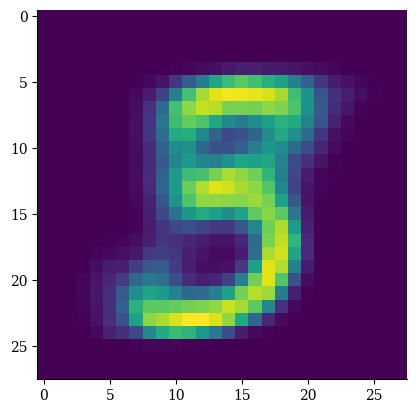

In [6]:
component = torch.multinomial(weights, 1).squeeze()
z = means[:,component]

with torch.no_grad():
    out = model.decode(z)

out_im = out.view(1, 28, 28)

plt.figure()
plt.imshow(out_im.permute(1,2,0))
plt.show()

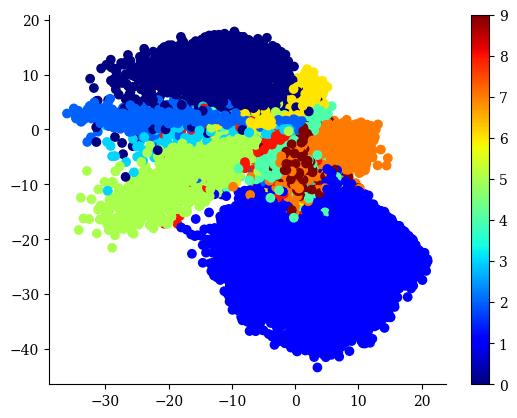

In [8]:
loader = DataLoader(dataset, batch_size=2048)
all_z = []
all_labels = []
model = model.to("cuda:0")
for data, label in loader:
    data = data.to("cuda:0")
    with torch.no_grad():
        z, means, log_vars, weights, components = model.project_to_latent(data)
        all_z.append(z.cpu())
        all_labels.append(label)

to_show = torch.cat(all_z, dim=0)
c = torch.cat(all_labels, dim=0)

plt.scatter(to_show[:,1], to_show[:,0], c=c, cmap="jet")
plt.scatter
plt.colorbar()

(np.float64(-38.92450284957886),
 np.float64(23.836381435394287),
 np.float64(-46.42244262695313),
 np.float64(20.917460632324218))

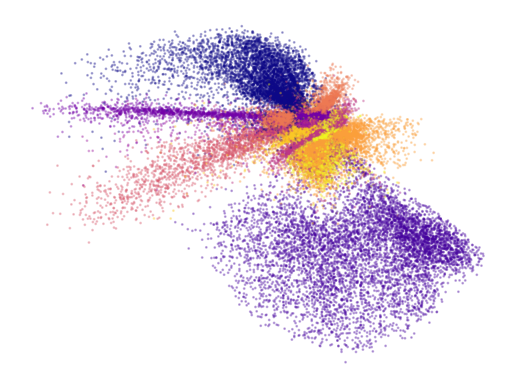

In [21]:
plt.scatter(to_show[:,1], to_show[:,0], c=c, cmap="plasma", alpha=0.3, s=1)
plt.axis("off")
# plt.colorbar()

In [25]:
with torch.no_grad():
    out = model.decode(model.prior_means)
out = out.view(-1, 1, 28, 28)

grid = make_grid(out, nrow=5, padding=2, normalize=True)

# Convert from (C,H,W) to (H,W,C) format for plotting
grid = grid.permute(1, 2, 0)

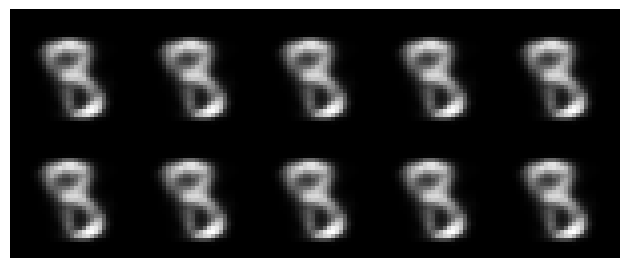

In [31]:
plt.figure()
plt.imshow(grid)
plt.axis("off")
plt.tight_layout()